In [18]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

In [19]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Exemple de la dyspnée (Lauritzen & Spiegelhalter (88))

La **dyspnée** peut être engendrée par une **tuberculose**, un
**cancer des poumons**, une **bronchite**, par plusieurs de ces
maladies, ou bien par aucune.

Un séjour récent en **Asie** augmente les chances de tuberculose,
tandis que **fumer** augmente les risques de cancer des poumons.
Des **rayons X** permettent de détecter une tuberculose ou un
cancer.

Un patient éprouve des difficultés à respirer. Dans quelle mesure
peut-on dire qu'il est atteint de dyspnée?

# Générer une base de données depuis un RB

1) Charger le BN correspondant depuis le fichier "res/asia.bif" et l'afficher.

2) Utiliser pyAgrum pour générer une base de données de 500000 exemples (dans le fichier "out/sample_asia.csv")

3) Vérifier la taille de la base de données

In [21]:
import pyAgrum.lib._utils.oslike as oslike
print("===\n  Size of the generated database\n===")
oslike.wc_l("out/sample_asia.csv")
print("\n===\n  First lines\n===")
oslike.head("out/sample_asia.csv")

===
  Size of the generated database
===
500000

===
  First lines
===
tuberculosis,lung_cancer,bronchitis,visit_to_Asia,positive_XraY,smoking,tuberculos_or_cancer,dyspnoea
1,0,0,1,0,0,0,0
1,1,1,1,1,1,1,1
1,1,0,1,1,0,1,0
1,1,0,1,1,0,1,0
1,1,1,1,1,1,1,1
1,1,0,1,1,0,1,0
1,1,0,1,0,1,1,0
1,0,0,1,0,0,0,0
1,1,1,1,1,0,1,1



# Apprentissage de paramètres depuis la base de données

1) Utiliser pyAgrum pour apprendre les paramètres d'un modèle (appeplé *bn2*) depuis une base de données.

Note : BNLearner peut prendre en paramètre le RB de départ afin de réutiliser les noms de variables et leurs labels.

Note 2 : Avant d'effectivement apprendre les paramètres, réutiliser le dag de *bn* comme dag initial dans le learner.

2) Comparer les CPTs du BN initial, *bn* et celui dont les paramètres ont été appris *bn2*.

In [34]:
from IPython.display import HTML

HTML('<table><tr><td style="text-align:center;"><h3>original BN</h3></td>'+
     '<td style="text-align:center;"><h3>Learned BN</h3></td></tr>'+
     '<tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('visit_to_Asia')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('visit_to_Asia')))
     +'</center></td></tr><tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('tuberculosis')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('tuberculosis')))
     +'</center></td></tr></table>')

# Apprentissage structurel depuis la base de données

## Différents algorithmes d'apprentissage 

PyAgrum propose plusieurs algorithmes pour apprendre la structure d'un BN :

- Local search with tabu-list
- Greedy Hill-Climbing
- K2 

1) En se basant sur l'exemple de code ci-dessous, comparer les différentes approches 

        learner=gum.BNLearner("out/sample_asia.csv",bn)
        learner.use ... un des algorithmes
        bn2=learner.learnBN()
        print("Learned in {0}ms".format(1000*learner.currentTime()))
        gnb.sideBySide(bn2,gnb.getInformation(bn2))
        kl=gum.ExactBNdistance(bn,bn2)
        kl.compute()

a) En utilisant Local search with tabu-list

b) L'algorithme de Greedy Hill Climbing

c) L'algorithme de K2, qui prend en paramètre un ordre de variables sous la forme d'une liste d'id (commencer avec l'ordre \[0,1,2,3,4,5,6,7\])

L'algorithme de K2 peut être très efficace si l'ordre choisi est bon !

d) Comparer le résultat précédent avec un K2 utilisant l'ordre \[7,6,5,4,3,2,1,0\]


# Suivre la courbe d'apprentissage

Il est possible de facilement suivre la courbe d'apprentissage d'un BN comme le montre la cellule ci-dessous.

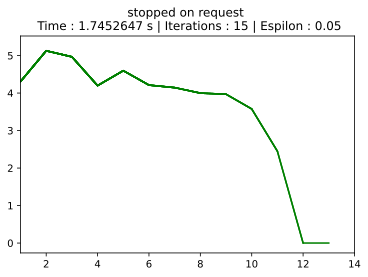

In [47]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
#learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(4) # no more than 3 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


1) Comparer les résultats des différents algorithmes

# Personnalisation des algorithmes

Les algorithmes d'apprentissage proposés dans pyAgrum sont fortement paramétrables, ce qui permet notamment de prendre en compte des connaissances a priori sur la structure à apprendre.

1) Apprendre la structure d'un BN depuis le fichier "out/sample_asia.csv" en jouant sur le paramètre MaxIndegree du learner. Observer la structure lorsque le paramètre vaut **1**.

2) Apprendre la structure depuis la même base de données mais cette fois-ci en utilisant nos connaissances sur la structure du BN :

+ Fumer a une influence directe sur la possibilité d'avoir un cancer du poumon
+ Une visite en Asie modifie le risque de contracter la tuberculose

Différents scores peuvent-être utilisés pour évaluer la qualité de l'apprentissage :

- BDeu (par défaut)
- K2
- AIC
- Log2Likelihood
- ...

3) Faire varier le score utilisé et observer l'influence de celui-ci sur la structure et la distance au bn initial en utilisant le code suivant :

        kl=gum.ExactBNdistance(bn,bn2)
        gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

# Taille de la base de données et apprentissage

Pour finir, nous allons observer l'influence de la taille de la base de données sur la qualité de l'apprentissage.

In [51]:
import IPython.display
rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]


1) En se basant sur l'exemple de code ci-dessous, comparer différentes approches en faisant varier les choix d'algorithme et de score.

        res="<table>"
        nbr=0
        l=[]
        for i in sizes:
                n=i+1
                oslike.rm("out/extract_asia.csv")
                oslike.head("out/sample_asia.csv",n,"out/extract_asia.csv")
                oslike.wc_l("out/extract_asia.csv")
                learner=gum.BNLearner("out/extract_asia.csv",bn) # using bn as template for variables
                learner.use ... un des algorithmes
                bn2=learner.learnBN()
                
                kl=gum.ExactBNdistance(bn,bn2)
                r=kl.compute()
                l.append(r['klPQ'])
                
                if nbr % rows == 0:
                        res+="<tr>"
                res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3")+"</td>"
                nbr+=1
                if nbr % rows == 0:
                        res+="</tr>"
        if nbr % rows!=0:
        res+="</tr>"
        res+="</table>"

        IPython.display.display(IPython.display.HTML(res))

        plot(sizes,l)
        print(l[-1])